# Test computational cost of Stochastic Programming (Scenario Optimisation)

Investigate computational complexity and runtime of scnearios optimisation for system design problem, where each scenario uses a realisation of uncertain battery efficiencies.

In [1]:
import os
import csv
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import inspect
from tqdm import tqdm
from multiprocessing import Pool

from citylearn.citylearn import CityLearnEnv
from linmodel import LinProgModel
from schema_builder import build_schema
from sys_eval import evaluate_system

In [2]:
# set up test parameters
dataset_dir = os.path.join('A37_example_test') # dataset directory
schema_path = os.path.join('data', dataset_dir, 'schema.json')
opex_factor = 10
pricing_dict = {'carbon':5e-1,'battery':1e3,'solar':2e3}

In [3]:
# Set up base parameters of system.
ids = [5,11,14,16,24,29]

base_kwargs = {
    'output_dir_path': os.path.join('data','A37_example_test'),
    'building_names': ['UCam_Building_%s'%id for id in ids],
    'battery_energy_capacities': [3127.0,2736.0,2746.0,2448.0,4788.0,4565.0], # from Annex 37
    'battery_power_capacities': [391.0,342.0,343.0,306.0,598.0,571.0], # from Annex 37
    'battery_efficiencies': None,
    'pv_power_capacities': [178.0,41.0,57.0,120.0,1349.0,257.0], # from Annex 37
    'load_data_paths': ['UCam_Building_%s.csv'%id for id in ids],
    'weather_data_path': 'weather.csv',
    'carbon_intensity_data_path': 'carbon_intensity.csv',
    'pricing_data_path': 'pricing.csv',
    'schema_name': 'schema_temp'
}

In [4]:
# Set up probabilistic model of effiencies and take draws
n_draws = 100
mu = 0.85
sigma = 0.1
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_draws,len(ids)))
eta_samples = np.clip(eta_samples,0,1)

In [5]:
#num_scenarios = [1,2,3,5,8,10,15,20]
num_scenarios = [1,2]
runtimes = {}

for M in num_scenarios:
    print(f"# Scenarios: {M}")

    envs = []

    etas = [eta_samples[k] for k in range(M)] # get M samples

    for m in range(M):
        # Build schema.
        base_kwargs.update({
                'battery_efficiencies': etas[m]
            })
        schema_path = build_schema(**base_kwargs)

        # Initialise CityLearn environment object.
        envs.append(CityLearnEnv(schema=schema_path))

        if m == 0: # initialise lp object
            lp = LinProgModel(env=envs[m])
        else:
            lp.add_env(env=envs[m])

    lp.set_time_data_from_envs()
    lp.generate_LP(clip_level='b',design=True,pricing_dict=pricing_dict,opex_factor=opex_factor)
    lp.set_LP_parameters()

    start = time.time()
    lp_results = lp.solve_LP(verbose=False,ignore_dpp=True)
    end = time.time()

    print(lp_results['battery_capacities'],lp_results['solar_capacities'])

    runtimes.update({M: end-start})
    print(f"Solve time: {round(runtimes[M],1)}s")

# Scenarios: 1
[1092.89238905  941.00304029  826.15848018  683.01211202 2038.85998919
 1625.17082555] [ 799.03381643  669.6033027   618.17180617  587.39108064 1325.45397272
 1099.80233592]
Solve time: 88.0s
# Scenarios: 2
[1086.9778564   937.34670288  822.8533082   680.08287099 2000.69672294
 1627.31280371] [ 796.5176679   668.31254116  629.44806305  586.69508509 1294.27250959
 1107.05153871]
Solve time: 393.4s


In [6]:
# Fit linear trend to log(runtime)
trend = np.polyfit(np.log(list(runtimes.keys())),np.log(list(runtimes.values())),deg=1)
print(trend)

[2.15988515 4.47763595]


In [7]:
# Find max allowable samples
runtime_limit = 60*60*24*5
scenarios_limit = np.exp((np.log(runtime_limit) - trend[1])/trend[0])
print(scenarios_limit)

51.14786499530065


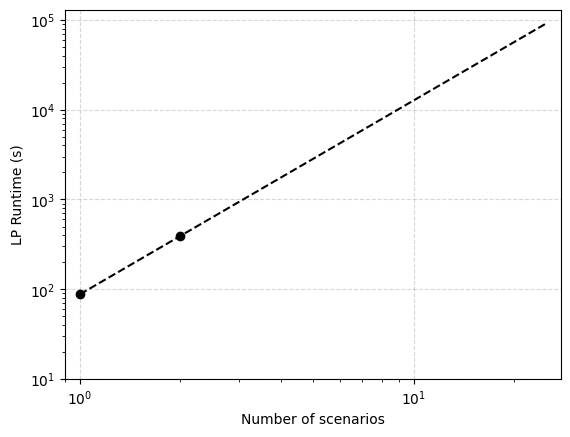

In [8]:
# Plot computational time results
max_scenarios = 25

plt.plot(runtimes.keys(),runtimes.values(),'ok')
plt.plot(np.arange(1,max_scenarios+1),np.exp(np.log(np.arange(1,max_scenarios+1))*trend[0] + trend[1]),'k--')
plt.xlabel("Number of scenarios")
plt.xscale('log')
plt.ylabel('LP Runtime (s)')
plt.yscale('log')
plt.xlim(0.9,max_scenarios*1.1)
plt.ylim(10)
plt.grid(True,'major',alpha=0.5,linestyle='--')
plt.show()

## Look at convergence of system cost MC estimate

In [9]:
# Define multiprocessing helper functions.

n_processes = 24 # for some reason more than this is an issue ...? Maybe a memory issue

def multi_proc_constr_and_eval_system(args_list):

    from sys_eval import construct_and_evaluate_system

    return construct_and_evaluate_system(*args_list)

def parallel_task(func, iterable, n_procs):
    # Adapted from solution to https://stackoverflow.com/questions/47313732/jupyter-notebook-never-finishes-processing-using-multiprocessing-python-3/47374811
    # NOTE: this function must be in the notebook
    # NOTE: in this workaround, the function passed to `parallel_task`
    # must do all of the importing it needs, and unwrap the arguments
    # (only a single argument can be passed)

    temp_path = f'./tmp_func.py'
    with open(temp_path, 'w') as file:
        file.write(inspect.getsource(func).replace(func.__name__, "task"))

    from tmp_func import task

    if __name__ == '__main__':
        pool = Pool(processes=n_procs)
        res = list(tqdm(pool.imap(task, iterable), total=len(iterable)))
        pool.close()
        os.remove(temp_path)
        return res
    else:
        raise "Not in Jupyter Notebook"

In [10]:
# Compute MC estimate of true system cost
mproc_args_list = [[lp_results['battery_capacities'],lp_results['solar_capacities'],eta_samples[n],base_kwargs,pricing_dict,opex_factor,n] for n in range(n_draws)]
cost_evals = parallel_task(multi_proc_constr_and_eval_system, mproc_args_list, n_procs=n_processes)

100%|██████████| 100/100 [20:06<00:00, 12.07s/it] 


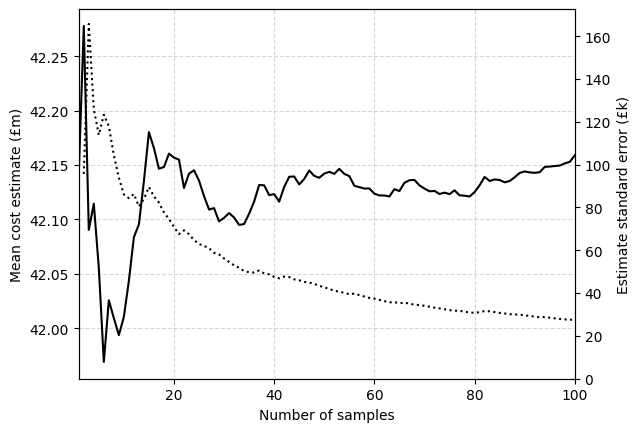

In [11]:
# Plot convergence of MC estimate
MC_means = [np.mean(cost_evals[:i]) for i in range(1,n_draws+1)]
MC_stnd_errors = [np.std(cost_evals[:i])/np.sqrt(i) for i in range(2,n_draws+1)]

fig,ax = plt.subplots()
ax.set_xlim(1,n_draws)
ax.set_xlabel("Number of samples")
ax.grid(True,'major',alpha=0.5,linestyle='--')

ax.plot(range(1,n_draws+1),np.array(MC_means)/1e6,'-k')
ax.set_ylabel('Mean cost estimate (£m)')
#ax.set_ylim(0)

# min_ax = ax.twinx()
# min_ax.plot(range(2,n_draws+1),(np.array(MC_stnd_errors)/MC_means[-1])*100,'k--')
# min_ax.set_ylabel('Estimate standard error (% of final mean)')
# min_ax.set_ylim(0)

min_ax_abs = ax.twinx()
min_ax_abs.plot(range(2,n_draws+1),np.array(MC_stnd_errors)/1e3,'k:')
min_ax_abs.set_ylabel('Estimate standard error (£k)')
min_ax_abs.set_ylim(0)

plt.show()

To find a reasonable value of MC estimates needed we could repeat this analysis for a number of seeds and find the average number of samples needed for the standard error to fall below a given threshold, e.g. £100k, are initially peaking

In [12]:
print(cost_evals)
print(MC_means)
print(MC_stnd_errors)

[42142429.59818608, 42413103.781625085, 41715653.38810098, 42186907.92305525, 41819409.910769254, 41537313.50577668, 42365379.14556925, 41894317.16280268, 41868890.41967765, 42162377.90944542, 42374599.67656853, 42524100.58719886, 42236471.32981332, 42652948.84725058, 42808761.689543605, 41946379.91304526, 41843098.46531169, 42174450.43894671, 42381600.235819384, 42089070.202801384, 42116384.31477841, 41582837.922842726, 42429940.166925296, 42218889.78836813, 41905384.45136993, 41767508.19462744, 41787580.71821509, 42144721.09551294, 41756984.05478603, 42198131.61834982, 42235760.512042336, 41975567.85842677, 41878701.465321705, 42120353.42624556, 42430598.48878852, 42504159.4633464, 42680421.70567491, 42120083.48283762, 41780920.74578516, 42158046.961113244, 41839358.2321268, 42687108.16053057, 42528821.4802475, 42150897.970494315, 41809060.41391724, 42366965.16481331, 42501283.61775362, 41906472.340543434, 42054114.01921142, 42331882.564395696, 42224304.10786636, 42048501.723929, 423